## SEQ2SEQ

In [ ]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
import random

print(tf.__version__)

2.8.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/gd8/korean-english-news-v1'

In [ ]:
def load_file(file_name):
    with open(file_path+'/{}'.format(file_name), "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")

    for sen in raw[0:100][::20]: 
        print(">>", sen)
    
    return raw

## Encoder 한국어 데이터 

In [ ]:
raw_kor = load_file('korean-english-park.train.ko')
raw_kor += load_file('korean-english-park.dev.ko')
raw_kor += load_file('korean-english-park.test.ko')
print('total data size:', len(raw_kor))

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data Size: 1000
Example:
>> 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> 그는 눈에 띄지 않게 행동하는 것으로 알려져있다. 그는 영국 시사잡지 타임즈에서 “파티에 잘 참석하지 않는다”며 자신의 생활에 대한 날조된 이야기를 즐기고 있다.
Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 수입

## Decoder 영어 데이터

In [ ]:
raw_en = load_file('korean-english-park.train.en')
raw_en += load_file('korean-english-park.dev.en')
raw_en += load_file('korean-english-park.test.en')
print('total data size:', len(raw_en))

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
Data Size: 1000
Example:
>> After keeping the world's most powerful supercomputer to themselves for a year, government researchers showed off the $110 million wonder and said it might help save the world from nuclear war.
>> The head of the U.N. weapons inspection

In [ ]:
raw = zip(raw_kor, raw_en)

In [ ]:
set_raw = set(raw)

In [ ]:
len(set_raw)

81959

In [ ]:
cleaned_corpus_kor, cleaned_corpus_eng =zip(*set_raw)

In [ ]:
print('korean data size:', len(cleaned_corpus_kor))
print('english data size:', len(cleaned_corpus_eng))

korean data size: 81959
english data size: 81959


# Preprocessing

In [ ]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [ ]:
enc_corpus = []
dec_corpus = []

# num_examples = 30000
cnt=0

for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng, s_token=True, e_token=True)

    if len(temp_kor) <= 40:
        enc_corpus.append(temp_kor)
        dec_corpus.append(temp_eng)
    
print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[100])   
print("English:", dec_corpus[100])  

korean data size: 17055
english data size: 17055
Korean: 그들은 시애틀 내시빌 그리고 샌디에이고에서 공연을 합니다 .
English: <start> they ll play in seattle nashville and san diego . <end>


In [ ]:
#Mecab 설치
%%capture
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
from konlpy.tag import Mecab

ModuleNotFoundError: ignored

In [ ]:
from konlpy.tag import Mecab

vocab_size = 50000
def tokenize(corpus, kor=False, eng=True):
    if kor:
        mecab = Mecab()
        morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(morph)

        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    if eng:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [ ]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus, kor=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, eng=True)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 41796
English Vocab Size: 17325


## BahdanauAttention
Seq2Seq 구조에서 Context vector가 인코더의 문장에 대한 정보를 충분히 담지 못한다!

인코더의 역할은 소스 문장을 적절한 임베딩 벡터로 변환하는 것..! Encoder Rnn의 hidden state의 조합으로 $y_i$마다 다르게 조합해보자! Decoder RNN에서 $y_i$를 선택할 때 Encoder RNN의 $h_j$를  얼마만큼 이용할지를 $a_{ij}$로 정의, 이거를 attention weight이라 부르고, 얘도 neural network에 의해 학습된다!

<hr>

# Attention(Q, K, V) = Attention Value

Q = Query :**t-1** 시점의 디코더 셀에서의 은닉 상태

K = Keys : 모든 시점의 인코더 셀의 은닉 상태들

V = Values : 모든 시점의 인코더 셀의 은닉 상태들

$a_t$를 Aligment Vecotr라고 정의하고, $a_t의 각 성분 a_t1, ....a_Tx를 활용해서 $h_1,...h_Tx를 

Weighted sum을 한 게 Context vector가 된다는 것!

$a_t = Softmax((Score(s_t-1,h_j)))_{j=1}^{Tx} \in \mathbb{R}$


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
      
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [ ]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 17326)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
#모델이 출력한 확률 분포와 정수 인덱스 답안을 비교해서 Cross-entropy 값을 구하겠다.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) #편의상 0을 전달
  loss = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype) #정답지에서 <pad> 토큰 찾아내서, 거기에 대한 loss는 구하지 않도록
  loss *= mask

  return tf.reduce_mean(loss)

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


In [ ]:
# Training Process

from tqdm import tqdm

EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 30: 100%|██████████| 54/54 [00:08<00:00,  6.29it/s, Test Loss 2.0764]


In [ ]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.font_manager as fm
import matplotlib as mpl

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

Input: 집에 가는 길은 이쪽입니다 .
Predicted translation: often took as you . <end> 


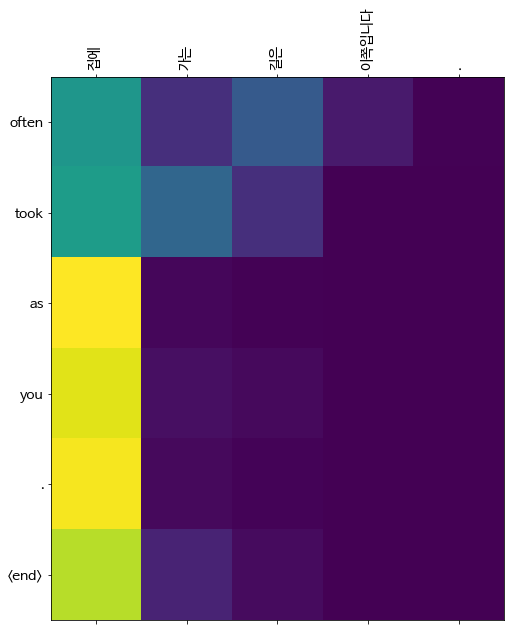

In [ ]:
translate("집에 가는 길은 이쪽입니다.", encoder, decoder)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
reference = [[ "The", "way", "home", "is", "this", "way"]]
candidate = ["often" "took" "as" "you"]
score1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)) # 1.0
print(score1)

0


Input: 그들은 시애틀 내시빌 그리고 샌디에이고에서 공연을 합니다 .
Predicted translation: they ll play in seattle nashville and san diego . <end> 


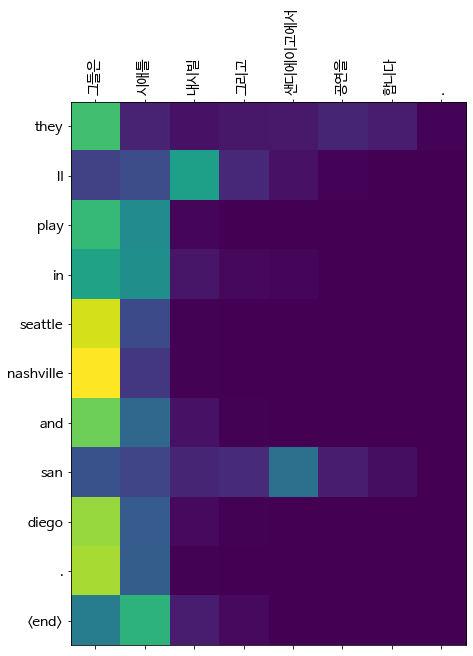

In [ ]:
translate(" 그들은 시애틀 내시빌 그리고 샌디에이고에서 공연을 합니다.", encoder, decoder)

In [ ]:
# 1-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(score)

0.75


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
from nltk.translate import bleu

reference = ["they" ,"ll", "play", "in", "seattle", "nashville", "and ", "san diego"]
candidate = 'they ll play in seattle nashville and san diego'.split()
bleu([reference], candidate)

0.5873949094699213

Input: 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다 .
Predicted translation: the issue of it just being a hardware expense is a serious impediment . <end> 


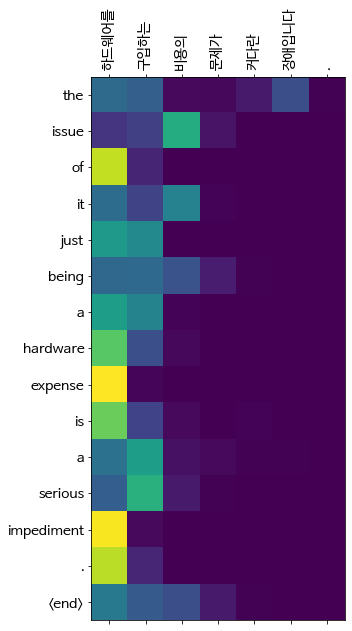

In [ ]:
translate("하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.", encoder, decoder)

 Bleu score는 기본적으로 Document 단위로 만들어졌기 때문에,문장 단위의 번역에는 여러 형태의 Smoothing 기법을 도입할 수 있다!:

<hr>

http://acl2014.org/acl2014/W14-33/pdf/W14-3346.pdf

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4
reference = ['the', 'cost', 'of', 'purchasing', 'hardware', 'is ', 'a', 'big', 'obstacle']
candidate = 'the issue of it just being a hardware expense is a serious impediment'.split()
bleu([reference], candidate,  smoothing_function=smoothie)

0.026480261910431388

## 회고

1. 원래 하고싶었던 목표가 있었지만... 제대로 이해하지 못해 노드의 흐름을 따라가는 것으로 제출!

2. 물론 이후 노드에 트랜스포머를 통해서 더 좋은 NMT를 구현할 수 있지만, 노드에 제시된 seq2seq을 개선하기 위해서, Luong attention을 도입한다던가, 밑시딥2에 나오는 seq2seq 개선안 중 입력데이터를 반전(reverse)시켜 학습하는 방식을 가져온다던가 하는 방안들이 있었으나.. 코딩실력 미숙으로 인한 포기...

3. 특히 Luong attention은  특정 하이퍼파라미터 D에 대해서 2D+1개만큼의 서브셋만큼 본다던가, 디코더의 Hidden State Vector를 구하는 방식이 간소화시킴을 통해 Computation path를 짧게 만들어서, 바다나우 어텐션보다 훨씬 더 많은 레퍼런스 코드들을 찾아볼 수 있을 것 같은데... 생각보다 찾아볼 수 있는 자료가 많지않다. 

4. 번역 과제에서 주로 쓰이는 Bleu score랑 이에 대한 여러 smoothing 기법에 대해서 한번 더 구체적으로 알아볼 필요가 있다!
